## Load,Clean And Preprocess Customer Purchase *History*

In [22]:
import pandas as pd
import re

In [23]:
# Load the Dataset
df = pd.read_csv("/content/online_retail_II.csv")

In [24]:

# Assuming 'InvoiceDate' column contains the date information
# Convert 'InvoiceDate' to datetime objects if it's not already
excel_file['InvoiceDate'] = pd.to_datetime(excel_file['InvoiceDate'])

# Filter data for 2009-2010 and 2010-2011
df_2009_2010 = excel_file[
    (excel_file['InvoiceDate'].dt.year == 2009) |
    (excel_file['InvoiceDate'].dt.year == 2010)
]
df_2010_2011 = excel_file[
    (excel_file['InvoiceDate'].dt.year == 2010) |
    (excel_file['InvoiceDate'].dt.year == 2011)
]

# Clean StockCode to remove alphabet characters
def clean_stock_code(code):
    if isinstance(code, str):
        return ''.join(re.findall(r'\d+', code))
    return str(code)

df_2009_2010['StockCode'] = df_2009_2010['StockCode'].apply(clean_stock_code)
df_2010_2011['StockCode'] = df_2010_2011['StockCode'].apply(clean_stock_code)

# Combine both datasets
df = pd.concat([df_2009_2010, df_2010_2011], ignore_index=True)

<ipython-input-24-13c61af17fe5>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_2010_2011['StockCode'] = df_2010_2011['StockCode'].apply(clean_stock_code)


In [25]:
# Drop rows with no CustomerID
df.dropna(subset=['Customer ID'], inplace=True)

# Remove cancelled orders (Invoice starts with 'C')
df = df[~df['Invoice'].astype(str).str.startswith('C')]

# Calculate Total Price
df['TotalPrice'] = df['Quantity'] * df['Price']

<ipython-input-25-9b9b916024f3>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['TotalPrice'] = df['Quantity'] * df['Price']


## Feature Engineering – Frequency, Recency, AOV

In [26]:
import datetime as dt

# Set reference date (1 day after last invoice date)
ref_date = df['InvoiceDate'].max() + dt.timedelta(days=1)

# Aggregate customer features
customer_df = df.groupby('Customer ID').agg({
    'InvoiceDate': lambda x: (ref_date - x.max()).days,   # Recency
    'Invoice': 'nunique',                                  # Frequency (number of purchases)
    'TotalPrice': 'sum'                                    # Total spending (used for LTV)
}).reset_index()

customer_df.columns = ['CustomerID', 'Recency', 'Frequency', 'Monetary']

# Calculate AOV (Average Order Value)
customer_df['AOV'] = customer_df['Monetary'] / customer_df['Frequency']


## Train Regression Model (XGBoost)

In [29]:
# 📦 Import libraries
from xgboost import XGBRegressor
import joblib

# 🧾 Load your cleaned CSV with engineered features
df = pd.read_csv("LTV_predictions.csv")

# 🎯 Features and target
X = df[['Recency', 'Frequency', 'AOV']]
y = df['Monetary']

# ⚙️ Train XGBoost model
model = XGBRegressor(random_state=42)
model.fit(X, y)






XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

## Model Evaluation (MAE, RMSE)

In [30]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# Predict on training data
y_pred = model.predict(X)

#  Evaluate the model
mae = mean_absolute_error(y, y_pred)
rmse = np.sqrt(mean_squared_error(y, y_pred))

print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")

Mean Absolute Error (MAE): 31.26
Root Mean Squared Error (RMSE): 56.67


# Segment Customers by Predicted LTV

In [35]:
# Predict for all customers
customer_df['Predicted_LTV'] = model.predict(X)

# Segment into quartiles
customer_df['LTV_Segment'] = pd.qcut(customer_df['Predicted_LTV'], q=4, labels=['Low', 'Medium', 'High', 'Very High'])


## Feature Importance Plot

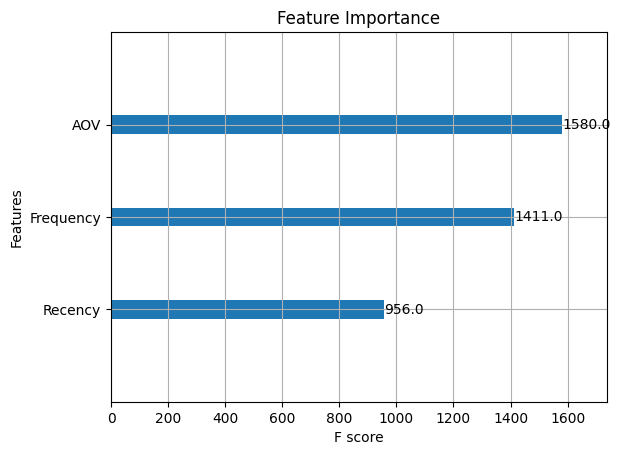

In [37]:
import matplotlib.pyplot as plt
from xgboost import plot_importance

plot_importance(model)
plt.title("Feature Importance")
plt.show()


## Visualize Predicted LTV & Segments

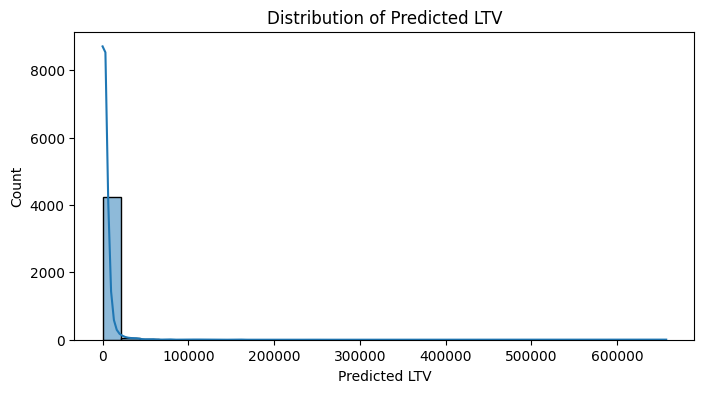

In [42]:
import seaborn as sns

# Histogram of predicted LTV
plt.figure(figsize=(8, 4))
sns.histplot(customer_df['Predicted_LTV'], bins=30, kde=True)
plt.title("Distribution of Predicted LTV")
plt.xlabel("Predicted LTV")
plt.ylabel("Count")
plt.show()




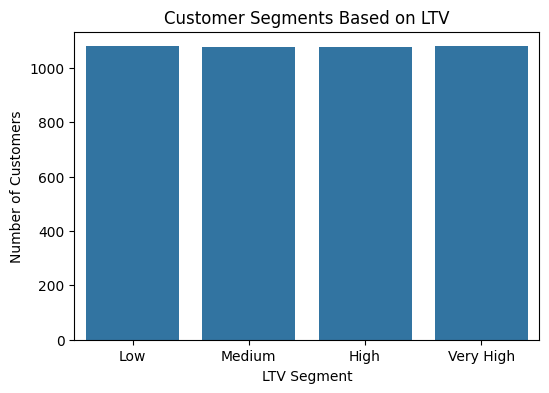

In [43]:
# Bar plot of segments
plt.figure(figsize=(6, 4))
sns.countplot(data=customer_df, x='LTV_Segment', order=['Low', 'Medium', 'High', 'Very High'])
plt.title("Customer Segments Based on LTV")
plt.ylabel("Number of Customers")
plt.xlabel("LTV Segment")
plt.show()

## Actual vs Predicted LTV Plot

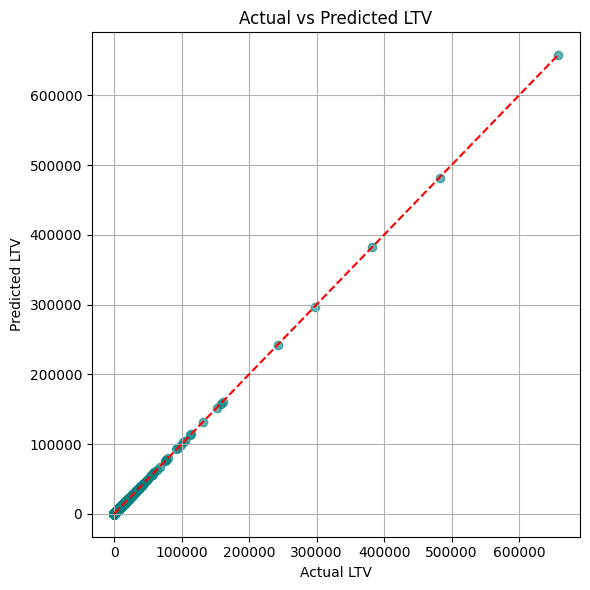

In [46]:

plt.figure(figsize=(6,6))
plt.scatter(y, y_pred, alpha=0.6, color='teal')
plt.plot([y.min(), y.max()], [y.min(), y.max()], '--r')
plt.xlabel("Actual LTV")
plt.ylabel("Predicted LTV")
plt.title("Actual vs Predicted LTV")
plt.grid(True)
plt.tight_layout()
plt.show()


## Export Deliverables

In [48]:
# Save predictions to CSV
customer_df.to_csv("LTV_predictions.csv", index=False)

#  Save the model correctly using joblib
joblib.dump(model, "ltv_model.pkl")

print(" Model saved as 'ltv_model.pkl'")


 Model saved as 'ltv_model.pkl'
